In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import plot_configs

In [ ]:
def load_results(csv_path: str) -> pd.DataFrame:
    """Load the results CSV file from the similarity scoring script."""
    try:
        df = pd.read_csv(csv_path)
        return df
    except Exception as e:
        raise

def get_similarity_score_columns(df: pd.DataFrame) -> list:
    """Get all columns that contain similarity scores."""
    score_cols = [col for col in df.columns if col.endswith('_similarity_score')]
    return score_cols

def extract_method_names(score_columns: list) -> list:
    """Extract method names from score column names for cleaner labels."""
    method_names = []
    for col in score_columns:
        # Remove 'paraphrased_transcript_' prefix and '_similarity_score' suffix
        method_name = col.replace('paraphrased_transcript_', '').replace('_similarity_score', '')
        # Clean up the name for better readability
        method_name = method_name.replace('_', ' ').title()
        method_names.append(method_name)
    return method_names

def calculate_statistics(df: pd.DataFrame, score_columns: list) -> tuple:
    """Calculate mean and standard error for each score column."""
    means = []
    errors = []
    
    for col in score_columns:
        scores = df[col].dropna()
        if len(scores) > 0:
            mean_score = scores.mean()
            std_error = scores.std() / np.sqrt(len(scores))  # Standard error
            means.append(mean_score)
            errors.append(std_error)
        else:
            means.append(np.nan)
            errors.append(np.nan)
    
    return means, errors

def calculate_null_baseline(df: pd.DataFrame) -> float:
    """Calculate the average null comparison score."""
    null_scores = df['null_comparison'].dropna()
    if len(null_scores) > 0:
        null_mean = null_scores.mean()
        return null_mean
    else:
        return None


def print_summary_statistics(df: pd.DataFrame, score_columns: list, null_baseline: float):
    """Print summary statistics to console."""
    print("\n" + "="*60)
    print("SIMILARITY SCORE SUMMARY")
    print("="*60)
    
    for col in score_columns:
        scores = df[col].dropna()
        if len(scores) > 0:
            method_name = col.replace('paraphrased_transcript_', '').replace('_similarity_score', '')
            print(f"\n{method_name.upper().replace('_', ' ')}:")
            print(f"  Mean: {scores.mean():.3f}")
            print(f"  Std:  {scores.std():.3f}")
            print(f"  Min:  {scores.min():.3f}")
            print(f"  Max:  {scores.max():.3f}")
            print(f"  N:    {len(scores)}")
    
    if null_baseline is not None:
        null_scores = df['null_comparison'].dropna()
        print(f"\nNULL BASELINE:")
        print(f"  Mean: {null_baseline:.3f}")
        print(f"  Std:  {null_scores.std():.3f}")
        print(f"  N:    {len(null_scores)}")
    
    print("\n" + "="*60)



In [26]:
def create_bar_plot(method_names: list, means: list, errors: list, null_baseline: float, output_path: str = "similarity_scores_plot.png"):
    """Create and save the bar plot with error bars."""
    # Set up the plot style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create the figure
    fig, ax = plt.subplots(figsize=(3, 3.25))
    
    # Create the bar plot
    x_pos = np.arange(len(method_names))
    bars = ax.bar(x_pos, means, yerr=errors, capsize=5, alpha=0.8, 
                  color=sns.color_palette("husl", len(method_names)))
    
    # Add null baseline as horizontal dashed line
    if null_baseline is not None:
        ax.axhline(y=null_baseline, color='red', linestyle='--', linewidth=2, 
                   label=f'Null Baseline ({null_baseline:.2f})', alpha=0.8)
    
    # Customize the plot
    ax.set_xlabel('Logit Lens Method', fontsize=8)
    ax.set_ylabel('Similarity Score', fontsize=8)
    
    # Set x-axis labels
    ax.set_xticks(x_pos)
    ax.set_xticklabels(method_names, rotation=45, ha='right', fontsize=6)
    
    # Set y-axis limits
    ax.set_ylim(0, 10)
    
    # Add grid for better readability
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on top of bars
    for i, (bar, mean, error) in enumerate(zip(bars, means, errors)):
        if not np.isnan(mean):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + error + 0.1,
                   f'{mean:.2f}', ha='center', va='bottom', fontsize=6)
    
    plt.yticks([0,5,10], fontsize=6)
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.show()


SIMILARITY SCORE SUMMARY

LAYER:
  Mean: 7.918
  Std:  1.470
  Min:  0.000
  Max:  9.000
  N:    49

LAYER AVGED:
  Mean: 7.898
  Std:  1.674
  Min:  0.000
  Max:  9.000
  N:    49

LAYER AVGED CONF:
  Mean: 8.469
  Std:  0.504
  Min:  8.000
  Max:  9.000
  N:    49

NULL BASELINE:
  Mean: 5.980
  Std:  2.905
  N:    49



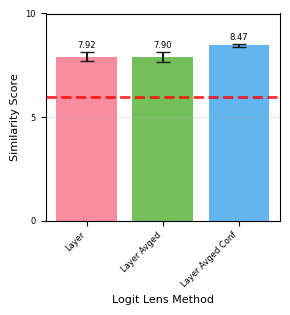


METHODS PERFORMING ABOVE NULL BASELINE (5.98):
  Layer: 7.92 (+1.94)
  Layer Avged: 7.90 (+1.92)
  Layer Avged Conf: 8.47 (+2.49)


In [27]:
input_csv_path = "transcript_similarity_scores.csv"  # Output from the previous script
output_plot_path = "figures/4b.png"

# Load the results
df = load_results(input_csv_path)

# Get similarity score columns
score_columns = get_similarity_score_columns(df)

# Check for null comparison column
if 'null_comparison' not in df.columns:
    null_baseline = None
else:
    null_baseline = calculate_null_baseline(df)

# Extract method names for cleaner labels
method_names = extract_method_names(score_columns)

# Calculate statistics
means, errors = calculate_statistics(df, score_columns)

# Print summary statistics
print_summary_statistics(df, score_columns, null_baseline)

# Create the plot
create_bar_plot(method_names, means, errors, null_baseline, output_plot_path)

# Additional analysis: Check which methods perform significantly better than baseline
if null_baseline is not None:
    print(f"\nMETHODS PERFORMING ABOVE NULL BASELINE ({null_baseline:.2f}):")
    for i, (method, mean) in enumerate(zip(method_names, means)):
        if not np.isnan(mean) and mean > null_baseline:
            improvement = mean - null_baseline
            print(f"  {method}: {mean:.2f} (+{improvement:.2f})")